In [1]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

#import warnings
#warnings.filterwarnings('ignore')

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


Detect if GPU available, otherwise use CPU

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


Load MNIST dataset of $28 \times 28$ images. Training does NOT use the test set.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [4]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Primal Network

This is the definition of the neural classifier for a custom number of layers (depth) and width. The first layer still has $28 \times 28$ features, and the output layer still has ten output classes (0-9).

In [33]:
class Net(nn.Module):
  
  #Constructor with default NN width = 256 and default NN depth = 3
  def __init__(self, width=256, depth=3):
    super().__init__()
    self.layers = nn.ModuleList()
    self.width = width
    self.depth = depth
    for w in range(0, depth - 1):
      if w == 0:
        self.layers.append(nn.Linear(in_features = 28*28, out_features = width))
      elif w == depth - 2:
        self.layers.append(nn.Linear(in_features = width, out_features = 10))    
      else:
        self.layers.append(nn.Linear(in_features = width, out_features = width))
  
  
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    t = t.reshape(-1, 28*28)
    for i in range(0, self.depth - 1):
      t = self.layers[i](t)
      self.z.append(t)
      if i != self.depth - 2:
        t = F.relu(t)
    return t

Provided training code using Adam.

In [34]:
def train(net, criterion, trainloader, depth, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(depth):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

Train the network using cross entropy loss. Note that this is equivalent to maximizing the KL-divergence.

In [35]:
net = Net(depth=5)
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, net.depth, 0.001)

Epoch 0 Iter: 0 Loss 2.3271470069885254
Epoch 0 Iter: 500 Loss 0.7162825465202332
Epoch 0 Iter: 1000 Loss 0.199073925614357
Epoch 0 Iter: 1500 Loss 1.7676581144332886
Epoch 0 Iter: 2000 Loss 0.4789253771305084
Epoch 0 Iter: 2500 Loss 0.11749890446662903
Epoch 0 Iter: 3000 Loss 0.006040720734745264
Epoch 0 Iter: 3500 Loss 1.0255928039550781
Epoch 0 Iter: 4000 Loss 0.2310912162065506
Epoch 0 Iter: 4500 Loss 0.3562363088130951
Epoch 0 Iter: 5000 Loss 0.007588902022689581
Epoch 0 Iter: 5500 Loss 0.2427343875169754
Epoch 0 Iter: 6000 Loss 0.007677924819290638
Epoch 0 Iter: 6500 Loss 1.3296210765838623
Epoch 0 Iter: 7000 Loss 0.0011598150013014674
Epoch 0 Iter: 7500 Loss 0.013396050781011581
Epoch 0 Iter: 8000 Loss 0.08768776059150696
Epoch 0 Iter: 8500 Loss 0.631874144077301
Epoch 0 Iter: 9000 Loss 0.6030470728874207
Epoch 0 Iter: 9500 Loss 0.100438192486763
Epoch 0 Iter: 10000 Loss 0.03144074231386185
Epoch 0 Iter: 10500 Loss 0.038854289799928665
Epoch 0 Iter: 11000 Loss 0.0360670536756515

In [31]:
test_iter = iter(testloader)

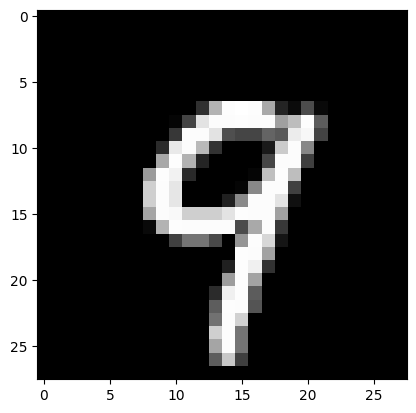

Classifier output: tensor([[-20.6649, -27.7976, -18.7386, -13.5673,  -6.0387, -13.6367, -35.5705,
         -10.2093, -19.5934,   3.9606]])
Classifier prediction: 9


In [38]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

Lorem ipsum...